In [1]:
from datasets import load_dataset
import os
import torch
import torch.optim as optim
from utils.lstm_gru_model import *
from utils.lstm_gru_utils import *
from utils.utils import *

c:\Users\Madhumitha K\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package punkt_tab to C:\Users\Madhumitha
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Madhumitha
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to C:\Users\Madhumitha
[nltk_data]     K\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Data preparation

In [2]:
dataset = load_dataset("rotten_tomatoes")
trn_dataset = dataset["train"]
val_dataset = dataset["validation"]
tst_dataset = dataset["test"]

In [3]:
# Obtain a list of unique words from the train set
sentences = trn_dataset["text"]
words = []

for i in range(len(sentences)):
    sentences[i] = simple_preprocess(sentences[i])

for sentence in sentences:
    for word in sentence:
        if word not in words:
            words.append(word)

# Pass it in to the load_word2vec function along w the relative filepath of the embedding file
word2vec_model = load_word2vec(vocab=words, filepath=r"data\embedding_matrix_oov.npy")

In [4]:
word_index = {
    word: i for i, word in enumerate(
        word2vec_model.index_to_key
    )
}

Dataloaders

In [5]:
trn_sentences, trn_labels = prepare_data(
    trn_dataset["text"],
    trn_dataset["label"],
    word_index=word_index
)
val_sentences, val_labels = prepare_data(
    val_dataset["text"],
    val_dataset["label"],
    word_index=word_index
)
tst_sentences, tst_labels = prepare_data(
    tst_dataset["text"],
    tst_dataset["label"],
    word_index=word_index
)

In [6]:
BATCH_SIZE = 32

trn_dataloader = create_dataloader(
    trn_sentences,
    trn_labels,
    BATCH_SIZE,
    shuffle=True)
val_dataloader = create_dataloader(
    val_sentences,
    val_labels,
    BATCH_SIZE,
    shuffle=False)
tst_dataloader = create_dataloader(
    tst_sentences,
    tst_labels,
    BATCH_SIZE,
    shuffle=False)

# Model

### Using Last State

In [7]:
# Model instantiation
model = LSTMGRUHybridModel(
    embed_dim=350,
    lstm_hidden_dim=128,
    gru_hidden_dim=128,
    num_classes=1,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
)

In [8]:
# Training
train_losses, val_accuracies = train_lstm_gru_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    criterion=torch.nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_mode= "last_state"
)

Epoch 1/100, Training Loss: 0.6937
Accuracy: 0.5000
Model saved
Epoch 2/100, Training Loss: 0.6921
Accuracy: 0.5300
Model saved
Epoch 3/100, Training Loss: 0.6353
Accuracy: 0.6876
Model saved
Epoch 4/100, Training Loss: 0.4515
Accuracy: 0.7120
Model saved
Epoch 5/100, Training Loss: 0.3247
Accuracy: 0.7073
Epoch 6/100, Training Loss: 0.2320
Accuracy: 0.7111
Epoch 7/100, Training Loss: 0.1698
Accuracy: 0.6989
Epoch 8/100, Training Loss: 0.1197
Accuracy: 0.6914
Epoch 9/100, Training Loss: 0.0901
Accuracy: 0.6979
Epoch 10/100, Training Loss: 0.0570
Accuracy: 0.6904
Epoch 11/100, Training Loss: 0.0393
Accuracy: 0.6951
Epoch 12/100, Training Loss: 0.0302
Accuracy: 0.7008
Epoch 13/100, Training Loss: 0.0230
Accuracy: 0.6932
Epoch 14/100, Training Loss: 0.0149
Accuracy: 0.6942
Early stopping triggered


c:\Y3 S1\SC4002 - Natural Language Processing\Group Assignment\sc4002\utils\lstm_gru_utils.py:171: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.

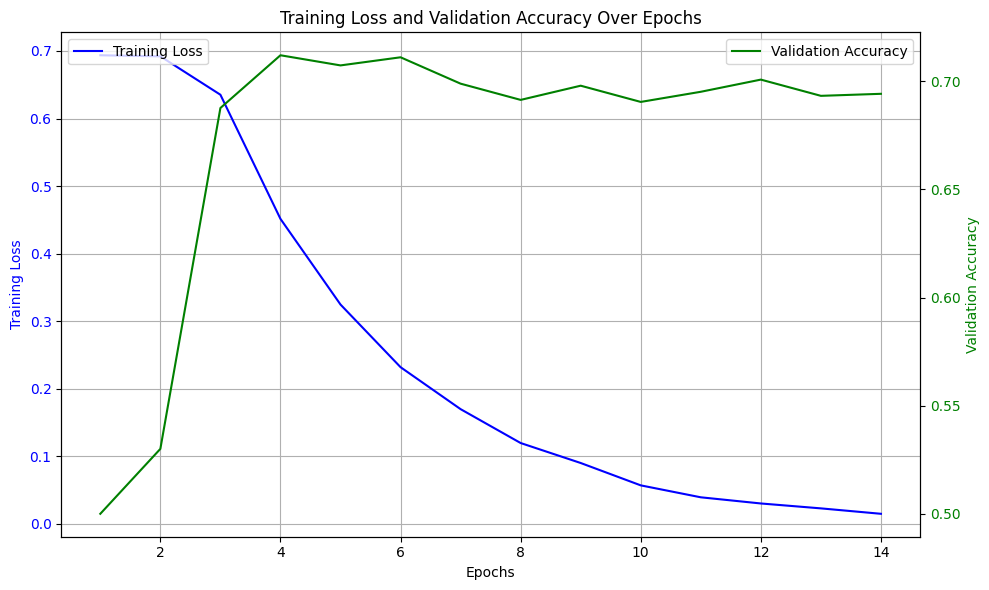

In [9]:
plot_training_progress(train_losses, val_accuracies)

In [10]:
last_state_test_accuracy = validate(model, tst_dataloader)
print(f"Test Accuracy: {last_state_test_accuracy:.4f}")

Accuracy: 0.7411
Test Accuracy: 0.7411


### Using Mean Max

In [11]:
# Model instantiation
model = LSTMGRUHybridModel(
    embed_dim=350,
    lstm_hidden_dim=128,
    gru_hidden_dim=128,
    num_classes=1,
    freeze_embeddings=False,  # Set to False to make embeddings trainable
    embedding_matrix=word2vec_model.vectors,
)

In [12]:
# Training
train_losses, val_accuracies = train_lstm_gru_model(
    model=model,
    trn_dataloader=trn_dataloader,
    val_dataloader=val_dataloader,
    optimizer=optim.Adam(model.parameters(), lr=0.0001),
    criterion=torch.nn.BCELoss(),
    epochs=100,
    model_save_path="modelfiles/",
    early_stopping_patience=10,
    load_best_model_at_end=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    train_mode= "mean_max"
)

Epoch 1/100, Training Loss: 0.6932
Accuracy: 0.5000
Model saved
Epoch 2/100, Training Loss: 0.6930
Accuracy: 0.5263
Model saved
Epoch 3/100, Training Loss: 0.6720
Accuracy: 0.6351
Model saved
Epoch 4/100, Training Loss: 0.5264
Accuracy: 0.7045
Model saved
Epoch 5/100, Training Loss: 0.3644
Accuracy: 0.7186
Model saved
Epoch 6/100, Training Loss: 0.2649
Accuracy: 0.6951
Epoch 7/100, Training Loss: 0.1905
Accuracy: 0.7223
Model saved
Epoch 8/100, Training Loss: 0.1315
Accuracy: 0.7167
Epoch 9/100, Training Loss: 0.0960
Accuracy: 0.7111
Epoch 10/100, Training Loss: 0.0684
Accuracy: 0.7036
Epoch 11/100, Training Loss: 0.0450
Accuracy: 0.7036
Epoch 12/100, Training Loss: 0.0306
Accuracy: 0.7017
Epoch 13/100, Training Loss: 0.0220
Accuracy: 0.7054
Epoch 14/100, Training Loss: 0.0174
Accuracy: 0.6764
Epoch 15/100, Training Loss: 0.0145
Accuracy: 0.7073
Epoch 16/100, Training Loss: 0.0095
Accuracy: 0.7036
Epoch 17/100, Training Loss: 0.0080
Accuracy: 0.7017
Early stopping triggered


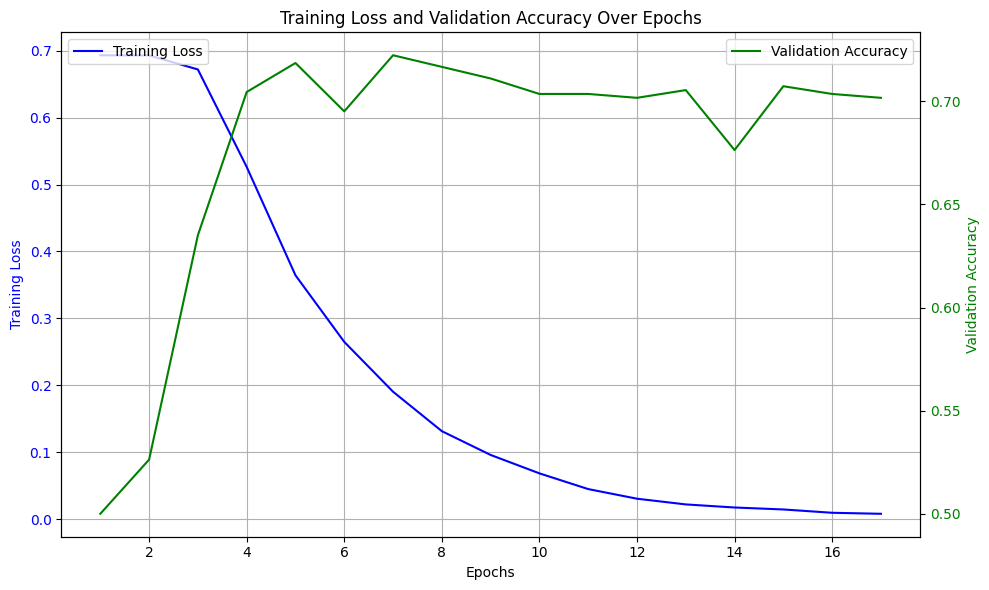

In [13]:
plot_training_progress(train_losses, val_accuracies)

In [14]:
mean_max_test_accuracy = validate(model, tst_dataloader)
print(f"Test Accuracy: {mean_max_test_accuracy:.4f}")

Accuracy: 0.7345
Test Accuracy: 0.7345


# Results

In [16]:
print(f"LSTM-GRU Hybrid model with Last State Test Accuracy:       {last_state_test_accuracy:.4f}")
print(f"LSTM-GRU Hybrid model with Mean Max Pool Test Accuracy:    {mean_max_test_accuracy:.4f}")

LSTM-GRU Hybrid model with Last State Test Accuracy:       0.7411
LSTM-GRU Hybrid model with Mean Max Pool Test Accuracy:    0.7345
